In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import json
from matplotlib import patheffects
from typing import Dict, Tuple, List
from utils import dref_dataframe, dump_dref

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    # out = out.reshape(((huge_pages + 31) // 32, 32))
    return pd.DataFrame(out)

def load_data(max_mem: int, modes: Dict[str, Path]) -> Tuple[pd.DataFrame, List[Dict[str, int]]]:
    datas = []
    for mode, p in modes.items():
        data = pd.read_csv(p / "out_0.csv")
        data["mode"] = mode
        datas.append(data)

    data = pd.concat(datas)
    data["small"] = max_mem - data["small"] * 2**12
    data["huge"] = max_mem - data["huge"] * 2**(12+9)
    data["time"] = data.index
    data = data.melt(
        id_vars=["mode", "time"],
        var_name="measurement",
        value_name="bytes",
        value_vars=["rss", "small", "huge", "cached"])

    times = [json.load((p / "times_0.json").open()) for p in modes.values()]
    for t in times:
        if "shrink" in t:
            t["drop"] = t["shrink"]
        if not isinstance(t["build"], list):
            t["build"] = [t["build"]]
        if not isinstance(t["delay"], list):
            t["delay"] = [t["delay"]]
    return data, times

def y_at(data: pd.DataFrame, x: int):
    return data[data["measurement"] == "huge"][(data["time"] - x).abs() < 2]["bytes"].max()

def relplot(max_mem: int, data: pd.DataFrame, times: List[Dict[str, int]]) -> Tuple[sns.FacetGrid, Dict[str, int]]:
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", hue="measurement", height=6, legend="brief")
    p.legend.set_title("")
    p.set_titles("{col_name}")
    p.set(ylabel="memory consumption (GiB)")
    p.set(xlabel="runtime (s)")
    p.set(ylim=(0, max_mem * 1.1))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])

    modes = data["mode"].unique()
    extra_keys = {}

    p.refline(y=max_mem, color=sns.crayons["Gray"])
    for i, time in enumerate(times):
        axis = p.facet_axis(0, i)
        celld = data[data["mode"] == modes[i]]


        tlast = 0
        j = 0
        prefix = ""
        for tbuild, tdelay in zip(time["build"], time["delay"]):
            axis.axvspan(
                xmin=tlast, xmax=tbuild, ymax=0.91, edgecolor=sns.crayons["Gray"],
                facecolor="white", zorder=-1, hatch="//")

            b_mid = tlast + (tbuild - tlast)/2
            axis.text(b_mid, max_mem * 1.02, "runtime", horizontalalignment="center",
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])

            gib_m = celld[(tlast <= celld["time"])
                & (celld["time"] < tbuild)
                & (celld["measurement"] == "rss")]["bytes"].sum() / 1024**3 / 60
            print(f"{modes[i]}: {gib_m:.2f} GiB*m, {tbuild - tlast} s")
            extra_keys[f"{modes[i]}/{j}/run/gib_m"] = gib_m
            extra_keys[f"{modes[i]}/{j}/run/time"] = tbuild - tlast

            gib = y_at(celld, tbuild + (tdelay - tbuild)/2) / 1024**3
            prefix += f"delay {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/{j}/delay/gib"] = gib
            tlast = tdelay
            j += 1

        tdelay = time["delay"][-1] if isinstance(time["delay"], list) else time["delay"]
        if "clean" in time and time["clean"]:
            axis.annotate(
                "clean",
                (tdelay, y_at(celld, tdelay) + max_mem/32),
                (tdelay, max_mem * 0.925),
                horizontalalignment="center",
                path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                arrowprops={"facecolor": sns.crayons["Violet (Purple)"]})
            tdelay = time["clean"]
            gib = y_at(celld, tdelay) / 1024**3
            prefix += f"clean {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/clean/gib"] = gib

        axis.annotate(
            "drop",
            (tdelay, y_at(celld, tdelay) + max_mem/32),
            (tdelay, max_mem * 0.85),
            horizontalalignment="center",
            path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
            arrowprops={"facecolor": "black"})
        gib = y_at(celld, time["drop"]) / 1024**3
        print(f"{modes[i]}: {prefix}drop {gib:.2f} GiB")
        extra_keys[f"{modes[i]}/drop/gib"] = gib

    return p, extra_keys


def visualize(max_mem: int, modes: Dict[str, Path], save_as: str | None = None) -> sns.FacetGrid:
    data, times = load_data(max_mem, modes)
    p, extra_keys = relplot(max_mem, data, times)
    if save_as:
        p.savefig(Path("compiling") / f"{save_as}.pdf")
        dref_dataframe(save_as, Path("compiling"), ["mode", "measurement", "time"], data)
        with (Path("compiling") / f"{save_as}_extra.dref").open("w+") as f:
            dump_dref(f, save_as, extra_keys)
    return p


## Linux

Basline: 4.35 GiB*m, 138 s
Basline: delay 2.17 GiB, clean 2.04 GiB, drop 1.76 GiB
LLfree: 5.39 GiB*m, 136 s
LLfree: delay 2.06 GiB, clean 1.92 GiB, drop 0.87 GiB


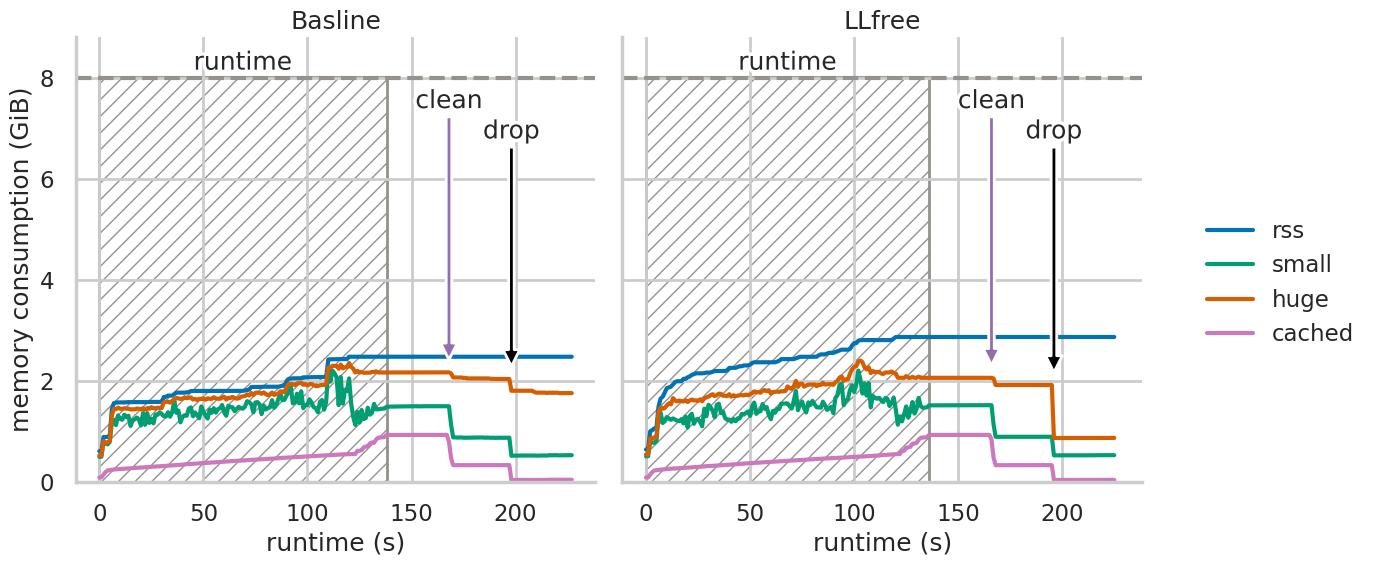

In [6]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "Basline": Path("compiling/latest-linux-base-manual"),
    "LLfree": Path("compiling/latest-linux-llfree-manual"),
}, "linux-auto")

Virtio Balloon: 4.28 GiB*s, 137 s
Virtio Balloon: delay 1.99 GiB, clean 1.96 GiB, drop 1.77 GiB
LLFree Balloon: 4.54 GiB*s, 136 s
LLFree Balloon: delay 2.11 GiB, clean 1.95 GiB, drop 0.87 GiB


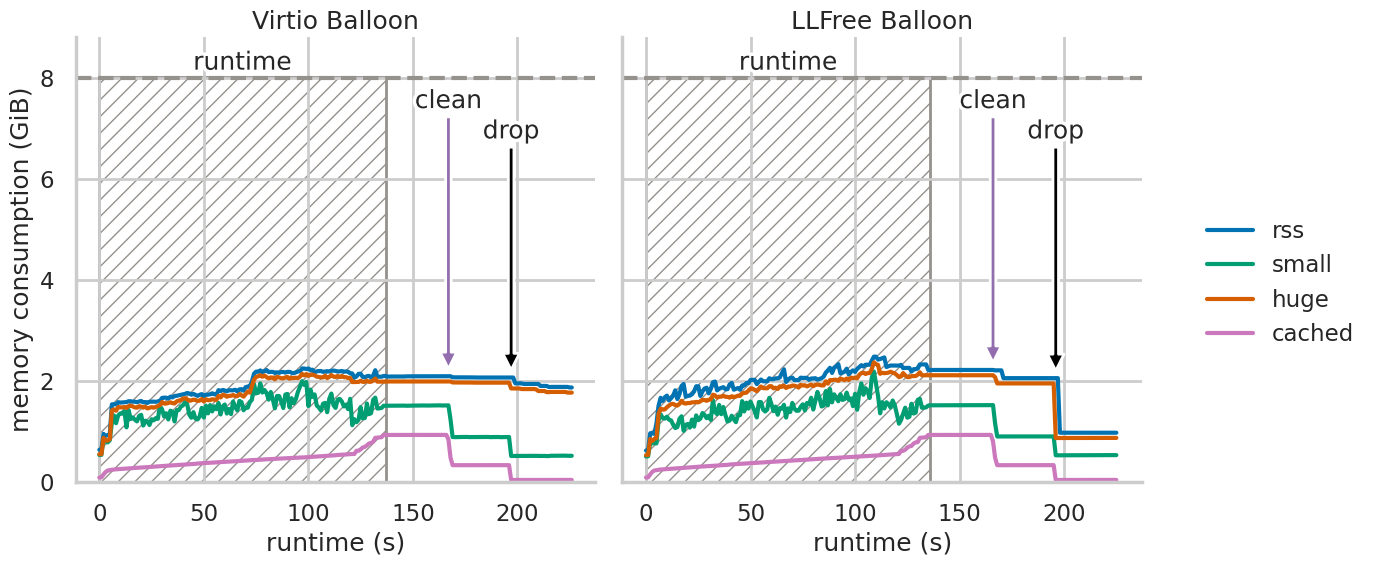

In [54]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "Virtio Balloon": Path("compiling/latest-linux-base-auto"),
    "LLFree Balloon": Path("compiling/latest-linux-llfree-auto"),
})

Virtio Balloon Huge: 4.28 GiB*s, 136 s
Virtio Balloon Huge: delay 2.04 GiB, clean 2.02 GiB, drop 1.88 GiB
LLFree Balloon VFIO: 4.64 GiB*s, 137 s
LLFree Balloon VFIO: delay 2.12 GiB, clean 1.96 GiB, drop 0.89 GiB


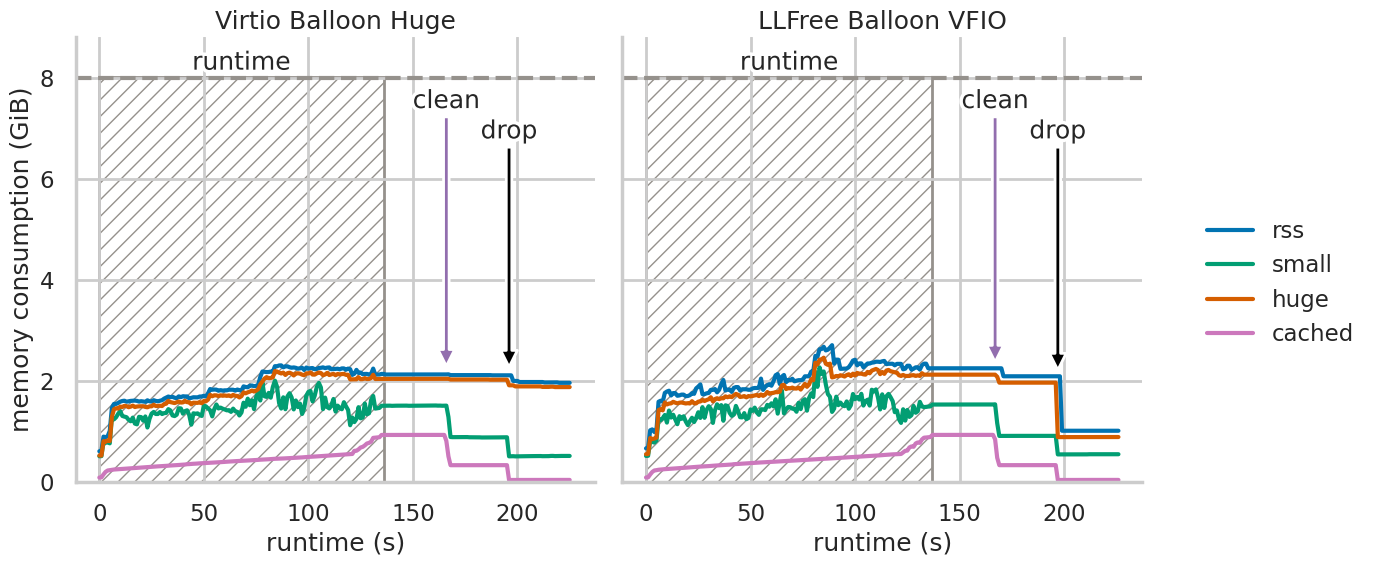

In [55]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "Virtio Balloon Huge": Path("compiling/latest-linux-huge-auto"),
    "LLFree Balloon VFIO": Path("compiling/latest-linux-llfree-auto-vfio"),
})

## Clang

Buddy Baseline: 305.31 GiB*s, 1508 s
Buddy Baseline: delay 12.65 GiB, clean 12.02 GiB, drop 9.05 GiB
LLFree Baseline: 306.97 GiB*s, 1478 s
LLFree Baseline: delay 10.66 GiB, clean 7.44 GiB, drop 2.17 GiB


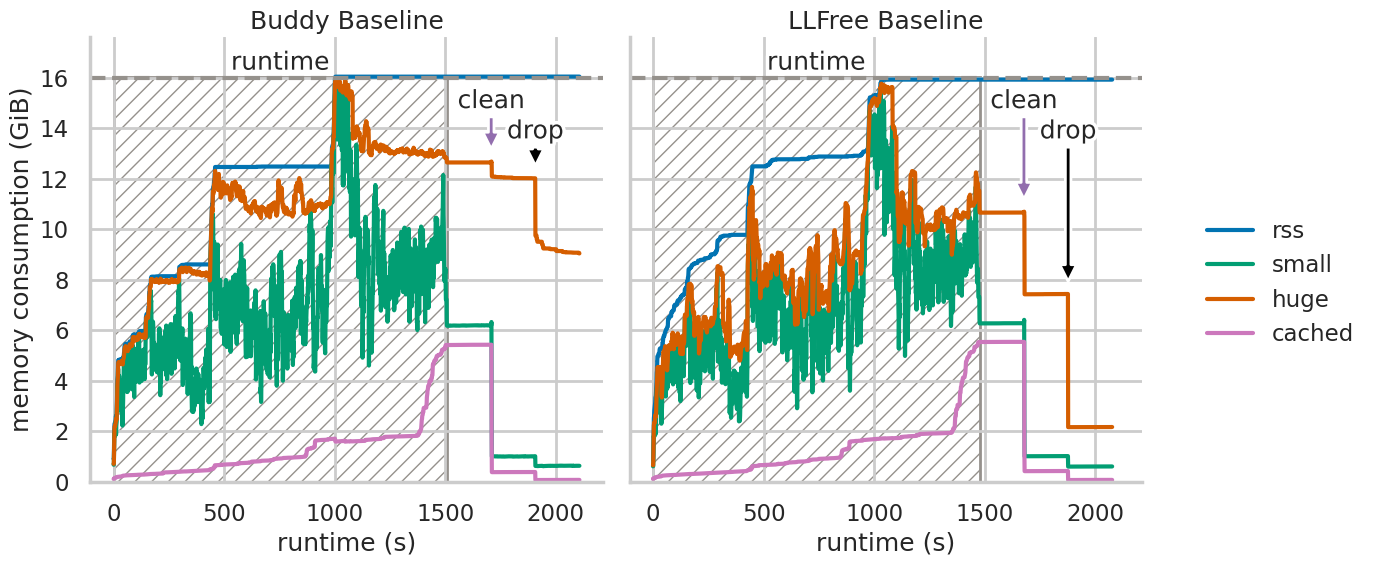

In [56]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Buddy Baseline": Path("compiling/latest-clang-base-manual"),
    "LLFree Baseline": Path("compiling/latest-clang-llfree-manual"),
})

Virtio Balloon: 269.61 GiB*m, 1495 s
Virtio Balloon: delay 12.16 GiB, clean 11.46 GiB, drop 8.93 GiB
LLFree Balloon: 223.70 GiB*m, 1475 s
LLFree Balloon: delay 10.85 GiB, clean 7.42 GiB, drop 2.18 GiB


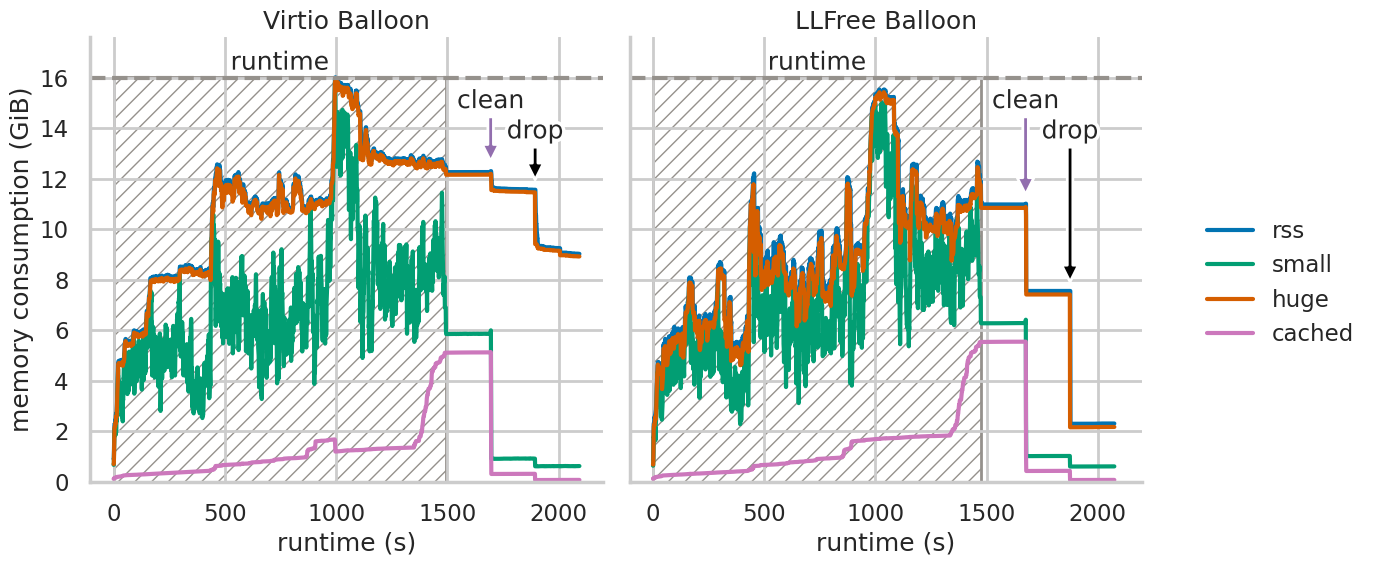

In [7]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Virtio Balloon": Path("compiling/latest-clang-base-auto"),
    "LLFree Balloon": Path("compiling/latest-clang-llfree-auto"),
}, "clang-auto")

Virtio Huge: 275.05 GiB*m, 1499 s
Virtio Huge: delay 12.68 GiB, clean 11.88 GiB, drop 9.28 GiB
LLFree VFIO: 226.18 GiB*m, 1478 s
LLFree VFIO: delay 11.06 GiB, clean 7.25 GiB, drop 2.05 GiB


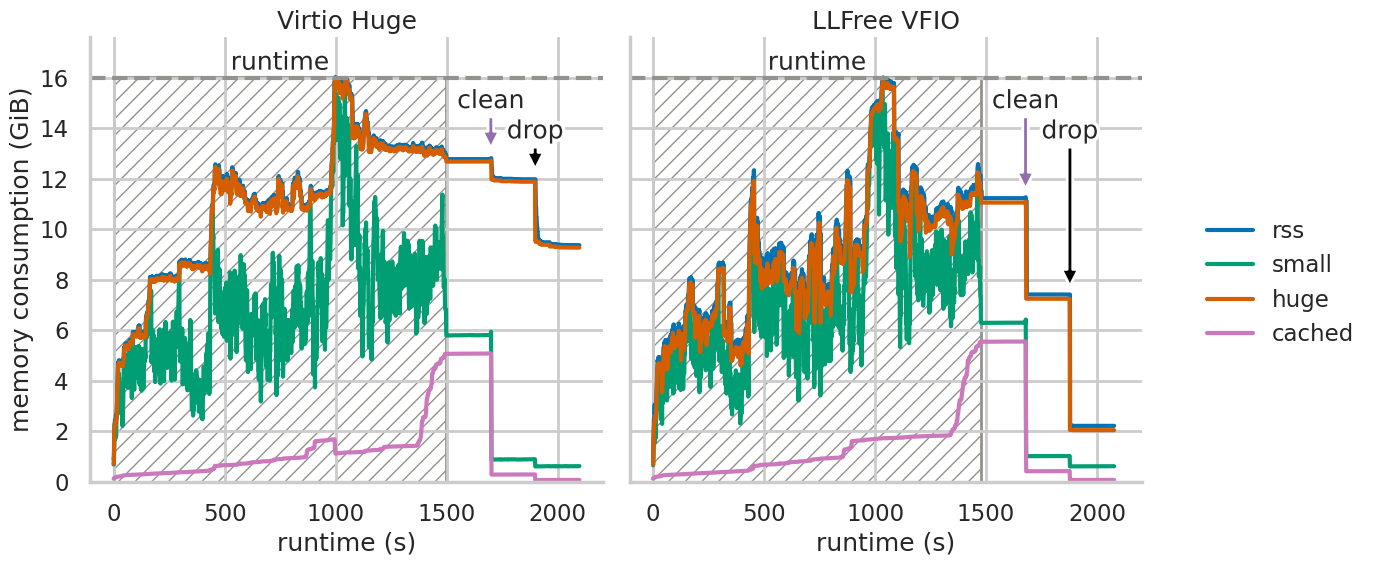

In [8]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Virtio Huge": Path("compiling/latest-clang-huge-auto"),
    "LLFree VFIO": Path("compiling/latest-clang-llfree-auto-vfio"),
}, "clang-huge-vfio")

## SPEC17 Blender

Virtio Balloon: 42.34 GiB*s, 332 s
Virtio Balloon: 43.04 GiB*s, 331 s
Virtio Balloon: delay 3.15 GiB, delay 4.92 GiB, drop 2.92 GiB
LLFree Balloon: 41.88 GiB*s, 328 s
LLFree Balloon: 42.16 GiB*s, 327 s
LLFree Balloon: delay 1.63 GiB, delay 2.06 GiB, drop 0.99 GiB


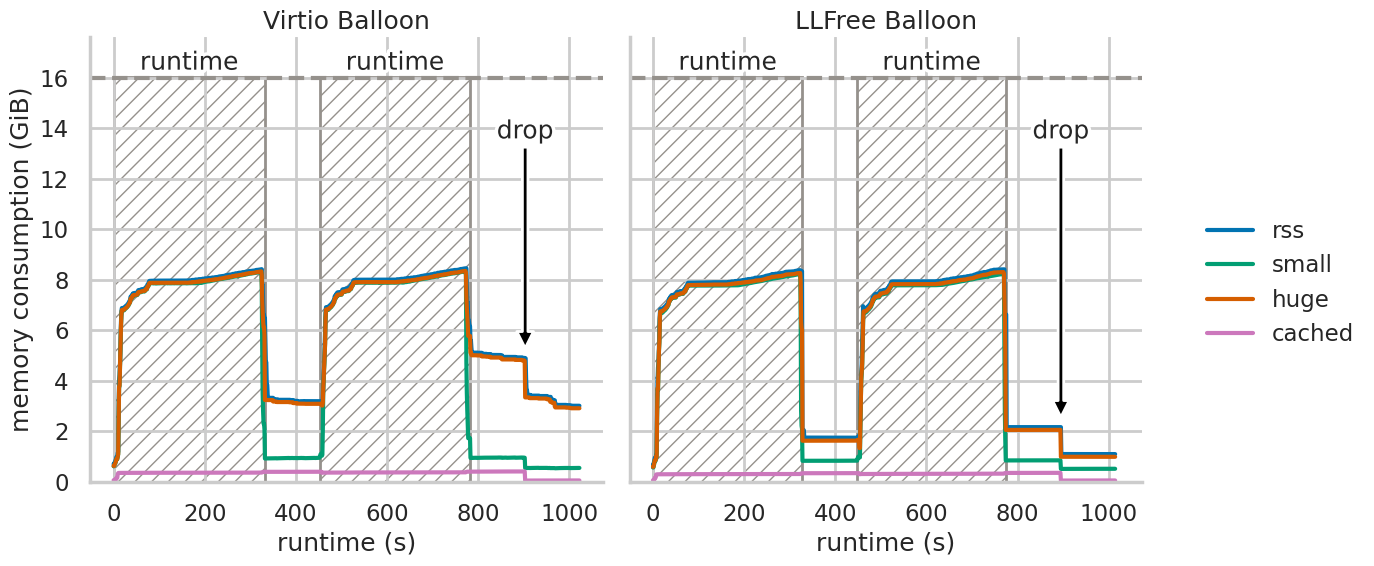

In [59]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Virtio Balloon": Path("compiling/240503-112937-blender-base-auto"),
    "LLFree Balloon": Path("compiling/240503-115338-blender-llfree-auto"),
})